## Goal: get SNPs both CLOSE to SJs (exonic, +- 10 bp) and within SSs themselves

* 1. Use these to compute what % of novel SJs only in hap1/hap2 have a +- 10bp SNP OR SNP in the SS (should be very close to another I'm computing) AND
* 2. Subset on just known SJs to compute a known SJ-proximal SNP density score that I can use to correlate against the % increase in ICs / SJs detected to predict how much novel splicing we're missing in populations / samples that we actually didn't profile here
* Here, I want to get the indivdual set of info abotu % for each category (10bp OR ss)


In [8]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [9]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [10]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

## We want to know what % of 1.5 NOVEL sjs that we 1. discover only in personal haplotypes that have snps +- 10 of splice junctions OR in splice sites

In [55]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel sjs
temp = df.loc[df.junction_novelty=='novel']

# get only the detection from mapping
temp = temp[['sj_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['sj_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1. get those that are detected uniquely in hap1/2 
# (ie those not in hg38)
temp = temp.loc[(temp.hg38==False)&
                ((temp.hap1+temp.hap2)>0)]

In [60]:
temp.head()
assert len(temp.index) == len(temp[['sj_id', 'cell_line_id']].drop_duplicates().index)
len(temp.index)

14298

In [62]:
# 3. process snp content in each sj
sj_snp_df = pd.DataFrame()
for c in meta_df['cell_line_id_1000g'].tolist():
    file = proc_cfg(expand(config['lr']['td_personal']['exon_vars']['sj_10nt_vcf_intersect'],
                cell_line_id=c)[0],
                od)
    df = pr.read_bed(file).df
    
    # just keep uniq. sj_ids
    df.rename({'ThickStart': 'sj_id'}, axis=1, inplace=True)
    df = df[['sj_id']]
    df = df.drop_duplicates()
    
    df['cell_line_id'] = c
    df['exon_10nt_has_var'] = True
    sj_snp_df = pd.concat([sj_snp_df, df], axis=0)

In [64]:
assert len(sj_snp_df.index) == len(sj_snp_df[['sj_id', 'cell_line_id']].drop_duplicates().index)
assert len(sj_snp_df.index) == len(sj_snp_df.drop_duplicates().index)

In [65]:
temp = temp.merge(sj_snp_df[['sj_id', 'cell_line_id', 'exon_10nt_has_var']],
                  how='left',
                  on=['sj_id', 'cell_line_id'])
temp.exon_10nt_has_var.fillna(False, inplace=True)

In [66]:
# 3. process snp content in each sj
sj_snp_df = pd.DataFrame()
for c in meta_df['cell_line_id_1000g'].tolist():
    file = proc_cfg(expand(config['lr']['td_personal']['exon_vars']['ss_2nt_vcf_intersect'],
                cell_line_id=c)[0],
                od)
    df = pr.read_bed(file).df

    # just keep uniq. sj_ids
    df.rename({'ThickStart': 'sj_id'}, axis=1, inplace=True)
    df = df[['sj_id']]
    df = df.drop_duplicates()
    
    df['cell_line_id'] = c
    df['ss_2nt_has_var'] = True
    sj_snp_df = pd.concat([sj_snp_df, df], axis=0)

In [67]:
assert len(sj_snp_df.index) == len(sj_snp_df[['sj_id', 'cell_line_id']].drop_duplicates().index)
assert len(sj_snp_df.index) == len(sj_snp_df.drop_duplicates().index)

In [68]:
temp = temp.merge(sj_snp_df[['sj_id', 'cell_line_id', 'ss_2nt_has_var']],
                  how='left',
                  on=['sj_id', 'cell_line_id'])
temp.ss_2nt_has_var.fillna(False, inplace=True)

In [74]:
temp['has_expl'] = temp.exon_10nt_has_var|temp.ss_2nt_has_var

temp.head()

,sj_id,cell_line_id,hap1,hap2,hg38,exon_10nt_has_var,ss_2nt_has_var,has_expl
0,GL000194.1_-_53893_55445,HG03729,False,True,False,False,False,False
1,GL000194.1_-_53893_55445,HG04217,False,True,False,False,False,False
2,GL000194.1_-_54956_55445,HG04217,False,True,False,False,False,False
3,KI270726.1_+_26127_26229,HG02261,True,False,False,False,False,False
4,chr10_+_100987611_100989643,NA19307,True,True,False,True,False,True


## testing

In [75]:
temp2 = pd.read_csv('250223_thing.tsv', sep='\t')
temp = temp.merge(temp2[['sj_id', 'cell_line_id', 'exon_12nt_has_var']],
                  how='left',
                  on=['sj_id', 'cell_line_id'])

In [79]:
temp.loc[(temp.has_expl!=temp.exon_12nt_has_var)&(temp.cell_line_id=='HG00621')].head()

,sj_id,cell_line_id,hap1,hap2,hg38,exon_10nt_has_var,ss_2nt_has_var,has_expl,exon_12nt_has_var
99,chr10_+_60792054_60792122,HG00621,True,True,False,False,False,False,True
1109,chr11_-_47143562_47176515,HG00621,True,False,False,False,False,False,True
1942,chr12_-_53665429_53667572,HG00621,True,True,False,False,False,False,True
2097,chr13_+_21176718_21176861,HG00621,True,True,False,False,False,False,True
2147,chr13_+_33752690_33752814,HG00621,False,True,False,False,False,False,True


In [80]:
# 3. process snp content in each sj
sj_snp_df = pd.DataFrame()
for c in meta_df['cell_line_id_1000g'].tolist():
    file = proc_cfg(expand(config['lr']['td_personal']['exon_vars']['ss_2nt_vcf_intersect'],
                cell_line_id=c)[0],
                od)
    df = pr.read_bed(file).df

    # just keep uniq. sj_ids
    df.rename({'ThickStart': 'sj_id'}, axis=1, inplace=True)
    
    df['cell_line_id'] = c
    df['ss_2nt_has_var'] = True
    sj_snp_df = pd.concat([sj_snp_df, df], axis=0)

In [81]:
sj_snp_df.loc[(sj_snp_df.cell_line_id=='HG00621')&(sj_snp_df.sj_id=='chr10_+_60792054_60792122')]

,Chromosome,Start,End,Name,Score,Strand,sj_id,ThickEnd,ItemRGB,cell_line_id,ss_2nt_has_var


In [82]:
# 3. process snp content in each sj
sj_snp_df = pd.DataFrame()
for c in meta_df['cell_line_id_1000g'].tolist():
    file = proc_cfg(expand(config['lr']['td_personal']['exon_vars']['sj_10nt_vcf_intersect'],
                cell_line_id=c)[0],
                od)
    df = pr.read_bed(file).df
    
    # just keep uniq. sj_ids
    df.rename({'ThickStart': 'sj_id'}, axis=1, inplace=True)
    
    df['cell_line_id'] = c
    df['exon_10nt_has_var'] = True
    sj_snp_df = pd.concat([sj_snp_df, df], axis=0)

In [83]:
sj_snp_df.loc[(sj_snp_df.cell_line_id=='HG00621')&(sj_snp_df.sj_id=='chr10_+_60792054_60792122')]

,Chromosome,Start,End,Name,Score,Strand,sj_id,ThickEnd,ItemRGB,cell_line_id,exon_10nt_has_var


## First do a boxplot w/ just total % that have a variant

In [47]:

# how many vars are we talking per cell line?
temp['n_sj'] = temp.groupby(['cell_line_id'])['sj_id'].transform('nunique')

# get # sjs that have explanation and perc
temp['n_sj_exp'] = temp.groupby(['cell_line_id', 'has_expl'])['sj_id'].transform('nunique')
temp['perc'] = (temp.n_sj_exp/temp.n_sj)*100

temp2 = temp[['cell_line_id', 'has_expl', 'n_sj', 'n_sj_exp', 'perc']].drop_duplicates()

In [50]:
temp2 = temp2.loc[temp2.has_expl==True]
len(temp2.index)

30

In [53]:
temp2.head()

,cell_line_id,has_expl,n_sj,n_sj_exp,perc
4,NA19307,True,467,189,40.471092
5,HG01952,True,577,206,35.701906
6,HG02261,True,695,267,38.417266
7,HG04217,True,514,184,35.797665
8,NA12878,True,463,209,45.140389


In [54]:
temp2.loc[temp2.cell_line_id=='HG00621']

,cell_line_id,has_expl,n_sj,n_sj_exp,perc
55,HG00621,True,764,284,37.172775


<AxesSubplot:ylabel='perc'>

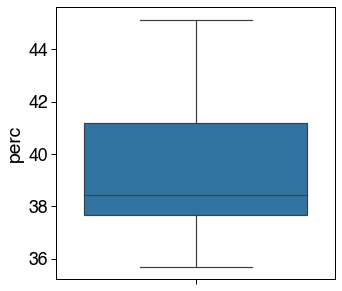

In [52]:
sns.boxplot(temp2,
            y='perc')

In [23]:
temp2.to_csv('250210_perc_novel_hg38_absent_sjs_w_variant_per_cell_line.tsv', sep='\t', index=False)

In [24]:
# what detection categories do we even have? 
temp[['exon_10nt_has_var', 'ss_2nt_has_var']].drop_duplicates()

,exon_10nt_has_var,ss_2nt_has_var
0,False,False
4,True,False
13,False,True
93,True,True


In [25]:
# how many vars are we talking per cell line?
temp['n_sj'] = temp.groupby(['cell_line_id'])['sj_id'].transform('nunique')

# for each combination of explanations, what % of sjs are explained?
# (and for each cell line)
temp['n_sj_w_explanation'] = temp.groupby(['cell_line_id', 'exon_10nt_has_var', 'ss_2nt_has_var'])['sj_id'].transform('nunique')
temp['perc_sj_w_explanation'] = (temp['n_sj_w_explanation']/temp['n_sj'])*100

In [26]:
keep_cols = ['exon_10nt_has_var', 'ss_2nt_has_var', 
              'n_sj', 'n_sj_w_explanation', 'perc_sj_w_explanation',
             'cell_line_id']
temp = temp[keep_cols]
print(len(temp.index))
temp = temp.drop_duplicates()
print(len(temp.index))

14456
119


In [27]:
temp['# SJs'] = temp.n_sj
temp['% SJs'] = temp.perc_sj_w_explanation

In [28]:
temp.rename({'exon_10nt_has_var': 'Exonic variant\n+-10bp from SJ', 
             'ss_2nt_has_var': 'SS variant'}, axis=1, inplace=True)

In [29]:
temp.set_index(['Exonic variant\n+-10bp from SJ', 'SS variant'], inplace=True)
temp.head()

n_sj  n_sj_w_explanation  \
Exonic variant\n+-10bp from SJ SS variant                             
False                          False        575                 356   
                               False        514                 330   
                               False        695                 428   
True                           False        467                 124   
                               False        577                 145   

                                           perc_sj_w_explanation cell_line_id  \
Exonic variant\n+-10bp from SJ SS variant                                       
False                          False                   61.913043      HG03729   
                               False                   64.202335      HG04217   
                               False                   61.582734      HG02261   
True                           False                   26.552463      NA19307   
                               False                   25.129983      HG01952   

                                           # SJs      % SJs  
Exonic variant\n+-10bp from SJ SS variant                    
False                          False         575  61.913043  
                               False         514  64.202335  
                               False         695  61.582734  
True                           False         467  26.552463  
                               False         577  25.129983

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


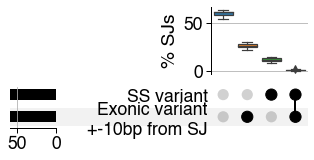

In [30]:
init_plot_settings()
fig = plt.figure(figsize=(10, 16))
# plot(example, fig=fig, element_size=None)
upset = upsetplot.UpSet(temp, intersection_plot_elements=0)  # disable the default bar chart
upset.add_catplot(
    kind='box',
    value='% SJs')
upset.plot(fig=fig)
# plt.suptitle('Novel personalized-GRCh38\nexclusive SJs')
plt.savefig('td_personal_perc_novel_pers_spec_sjs.pdf', dpi=500)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


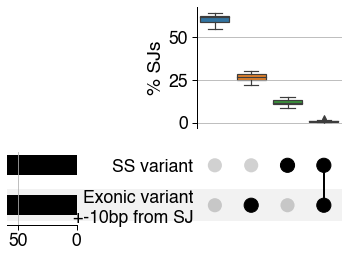

In [31]:
init_plot_settings()
fig = plt.figure(figsize=(6, 4))
# plot(example, fig=fig, element_size=None)
upset = upsetplot.UpSet(temp, intersection_plot_elements=0, element_size=None)  # disable the default bar chart
upset.add_catplot(
    kind='box',
    value='% SJs')
upset.plot(fig=fig)
# plt.suptitle('Novel personalized-GRCh38\nexclusive SJs')
plt.savefig('td_personal_perc_novel_pers_spec_sjs.pdf', dpi=500)

In [32]:
temp.head()

n_sj  n_sj_w_explanation  \
Exonic variant\n+-10bp from SJ SS variant                             
False                          False        575                 356   
                               False        514                 330   
                               False        695                 428   
True                           False        467                 124   
                               False        577                 145   

                                           perc_sj_w_explanation cell_line_id  \
Exonic variant\n+-10bp from SJ SS variant                                       
False                          False                   61.913043      HG03729   
                               False                   64.202335      HG04217   
                               False                   61.582734      HG02261   
True                           False                   26.552463      NA19307   
                               False                   25.129983      HG01952   

                                           # SJs      % SJs  
Exonic variant\n+-10bp from SJ SS variant                    
False                          False         575  61.913043  
                               False         514  64.202335  
                               False         695  61.582734  
True                           False         467  26.552463  
                               False         577  25.129983

In [33]:
temp.to_csv('250221_personal_hg38_unique_novel_explainability.tsv', sep='\t')
